In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

In [33]:
if torch.cuda.is_available():
    device = torch.device('cuda:2')
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda:2


2 variantes, 8 niveaux chacune.


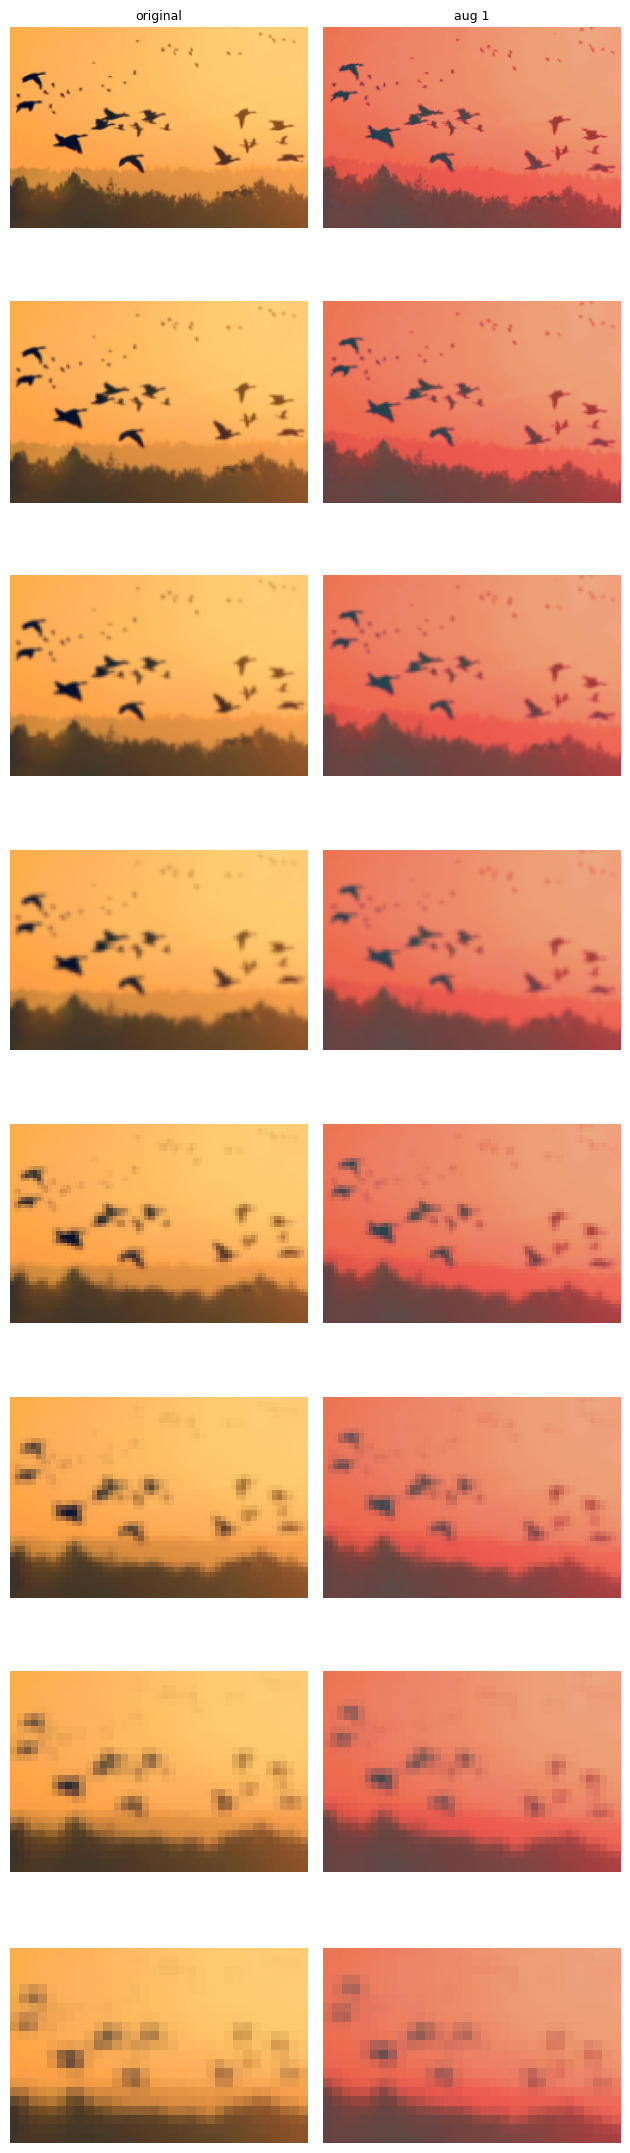

In [34]:
"""
SinGAN data-augmentation helper (torchvision.GaussianBlur)
──────────────────────────────────────────────────────────
• Produit l’image originale + N_AUG variantes aléatoires.
• Augmentations possibles :
      – flips horizontaux / verticaux
      – pad réflectif + rotation aléatoire (sans bordures noires)
      – ColorJitter
      – GaussianBlur (torchvision.transforms.GaussianBlur)
      – bruit gaussien additif
• Chaque variante finit en 3×H×W, valeurs ∈ [-1, 1].
• Construit pour chacune la pyramide d’échelles façon SinGAN.
"""

# ------------------------------------------------------------
# 0. Imports & utils
# ------------------------------------------------------------
import random, torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import resize as tv_resize
from torch.nn.functional import pad as Fpad
import torchvision.transforms as T

# ------------------------------------------------------------
# 1. Config
# ------------------------------------------------------------
IMG_PATH   = Path("images/birds.png")             # image de référence
MAX_DIM    = 250        # côté le plus long après resize initial
MIN_DIM    = 25         # côté mini à l’échelle la plus coarse
RATIO      = 4/3      # facteur de downscale entre niveaux

N_AUG      = 1          # nombre de variantes à générer
MAX_ROT    = 5         # rotation ±MAX_ROT°
PAD_RATIO  = 0.20       # pad(reflect) = PAD_RATIO × taille

JITTER     = dict(brightness=0.25,
                  contrast=0.25,
                  saturation=0.25,
                  hue=0.1)
BLUR_P     = 0.0        # probabilité d’appliquer le flou
BLUR_K     = (3, 5)     # noyaux possibles (entiers impairs)
NOISE_STD  = 0.05       # σ du bruit gaussien (dans [-1,1])

SEED       = 123        # fixer pour reproductibilité

# ------------------------------------------------------------
# 2. Bloc d’augmentation
# ------------------------------------------------------------
class AugmentVariant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.jitter  = T.ColorJitter(**JITTER)
        self.blur_op = [T.GaussianBlur(kernel_size=k, sigma=(0.3, 1.5))
                        for k in BLUR_K]

    @torch.no_grad()
    def forward(self, x):
        # x : 3×H×W ∈ [-1,1]
        C, H, W = x.shape

        # Flips
        # if random.random() < 0.5: x = torch.flip(x, [2])
        # if random.random() < 0.5: x = torch.flip(x, [1])

        # Pad-Rotate-Crop (pas de bordures noires)
        ph, pw = int(H * PAD_RATIO), int(W * PAD_RATIO)
        x = Fpad(x, (pw, pw, ph, ph), mode="reflect")
        angle = random.uniform(-MAX_ROT, MAX_ROT)
        x = TF.rotate(x, angle, expand=False)
        x = TF.center_crop(x, (H, W))

        # ColorJitter
        x = self.jitter((x+1)/2) * 2 - 1

        # GaussianBlur (p = BLUR_P)
        if random.random() < BLUR_P:
            blur = random.choice(self.blur_op)
            x = blur((x+1)/2) * 2 - 1

        # Bruit gaussien additif
        # if NOISE_STD > 0:
        #     x = x + torch.randn_like(x) * NOISE_STD

        return x.clamp(-1, 1)

# ------------------------------------------------------------
# 3. Charger & pré-traiter l’image
# ------------------------------------------------------------
torch.manual_seed(SEED); random.seed(SEED)

img   = Image.open(IMG_PATH).convert("RGB")
orig  = TF.to_tensor(img).to(device)                       # [0,1]
_, H0, W0 = orig.shape
scale = MAX_DIM / max(H0, W0)
orig  = tv_resize(orig, [int(H0*scale), int(W0*scale)], antialias=True)
orig  = orig * 2 - 1                            # [-1,1]

# ------------------------------------------------------------
# 4. Variantes (original + N_AUG)
# ------------------------------------------------------------
augmenter = AugmentVariant().to(device)
variants  = [orig] + [augmenter(orig.clone()) for _ in range(N_AUG)]

# ------------------------------------------------------------
# 5. Pyramides SinGAN
# ------------------------------------------------------------
def build_pyramid(img):
    levels = [img.unsqueeze(0)]              # fine → coarse (déjà sur device)
    while True:
        _, _, h, w = levels[-1].shape
        nh, nw = int(h / RATIO), int(w / RATIO)
        
        down = tv_resize(levels[-1], [nh, nw], antialias=True).to(device)  # <──
        levels.append(down)
        if nh < MIN_DIM or nw < MIN_DIM: break
    return levels

pyramids = [[lvl.to(device) for lvl in build_pyramid(v)] for v in variants]
print(f"{len(variants)} variantes, {len(pyramids[0])} niveaux chacune.")

# ------------------------------------------------------------
# 6. (Optionnel) Visualisation grille
# ------------------------------------------------------------
def show_grid(pyramids):
    rows, cols = len(pyramids[0]), len(pyramids)
    fig, axes  = plt.subplots(rows, cols, figsize=(3.2*cols, 2.8*rows))
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c] if rows > 1 else axes[c]
            img_np = (pyramids[c][r].cpu().squeeze(0).permute(1,2,0)+1)/2
            ax.imshow(img_np.clamp(0,1))
            if r == 0:
                ax.set_title("original" if c == 0 else f"aug {c}", fontsize=9)
            ax.axis('off')
    plt.tight_layout(); plt.show()

# Décommentez pour vérifier visuellement
show_grid(pyramids)


In [35]:
for x in pyramids[1] : 
    print(x.shape)
    print(x.device)

torch.Size([1, 3, 168, 249])
cuda:2
torch.Size([1, 3, 126, 186])
cuda:2
torch.Size([1, 3, 94, 139])
cuda:2
torch.Size([1, 3, 70, 104])
cuda:2
torch.Size([1, 3, 52, 78])
cuda:2
torch.Size([1, 3, 39, 58])
cuda:2
torch.Size([1, 3, 29, 43])
cuda:2
torch.Size([1, 3, 21, 32])
cuda:2


In [36]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [37]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [38]:
hidden_lowest_dim = 32
Genarators = []

N = len(pyramids[0])


for i in range(N):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
   
    

for gen in Genarators : 
     print(gen.n_hidden)



128
64
64
64
64
32
32
32


+ Boucle d'entrainement 

In [39]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




it scale 7:   0%|          | 0/4000 [00:00<?, ?it/s]

[scale 7 | it 0] 
[scale 7 | it 0]  LR = 5.00e-04

 mean lost 100 iter 19.0039

ratio_loss = 5.1636


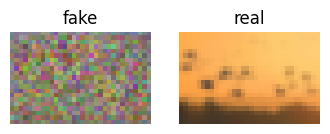

it scale 7:  15%|█▍        | 596/4000 [00:10<01:02, 54.31it/s]

[scale 7 | it 600] 
[scale 7 | it 600]  LR = 5.00e-04

 mean lost 100 iter 2.6653

ratio_loss = 81.1887


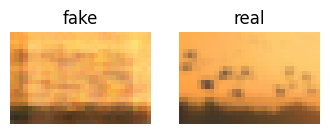

it scale 7:  30%|██▉       | 1197/4000 [00:21<00:50, 55.31it/s]

[scale 7 | it 1200] 
[scale 7 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 2.5985

ratio_loss = 128.8008


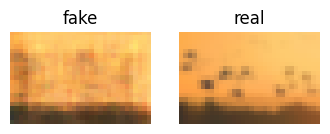

it scale 7:  45%|████▌     | 1800/4000 [00:32<00:40, 54.80it/s]

[scale 7 | it 1800] 
[scale 7 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 2.5669

ratio_loss = 115.7152


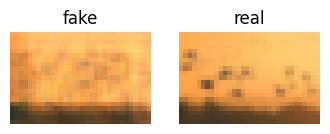

it scale 7:  60%|██████    | 2400/4000 [00:43<00:28, 55.97it/s]

[scale 7 | it 2400] 
[scale 7 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 2.5530

ratio_loss = 132.0639


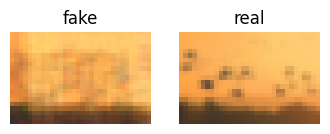

it scale 7:  75%|███████▌  | 3000/4000 [00:54<00:18, 55.22it/s]

[scale 7 | it 3000] 
[scale 7 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 2.5252

ratio_loss = 148.6668


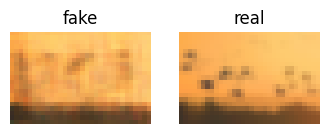

it scale 7:  90%|█████████ | 3600/4000 [01:05<00:07, 54.98it/s]

[scale 7 | it 3600] 
[scale 7 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 2.5258

ratio_loss = 190.0195


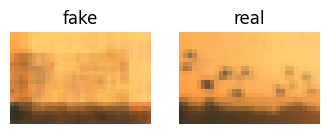

it scale 7: 100%|█████████▉| 3996/4000 [01:12<00:00, 55.03it/s]

[scale 7 | it 3999] 
[scale 7 | it 3999]  LR = 5.00e-04

 mean lost 100 iter 2.5124

ratio_loss = 155.9476


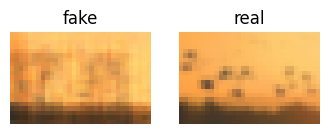

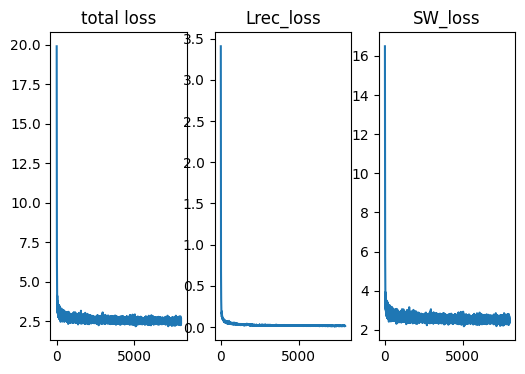

[init] copied weights from scale 7 → 6


it scale 6:   0%|          | 0/4300 [00:00<?, ?it/s]

[scale 6 | it 0] 
[scale 6 | it 0]  LR = 5.00e-04

 mean lost 100 iter 19.1522

ratio_loss = 5.0346


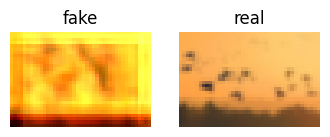

it scale 6:  14%|█▍        | 600/4300 [00:11<01:15, 48.70it/s]

[scale 6 | it 600] 
[scale 6 | it 600]  LR = 5.00e-04

 mean lost 100 iter 1.8279

ratio_loss = 64.5410


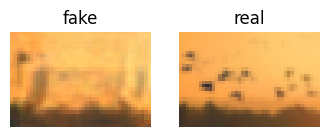

it scale 6:  28%|██▊       | 1200/4300 [00:23<00:57, 53.68it/s]

[scale 6 | it 1200] 
[scale 6 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 1.7571

ratio_loss = 86.3276


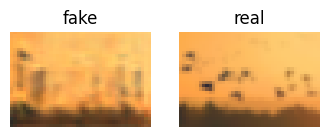

it scale 6:  42%|████▏     | 1800/4300 [00:34<00:47, 52.32it/s]

[scale 6 | it 1800] 
[scale 6 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 1.7030

ratio_loss = 72.6565


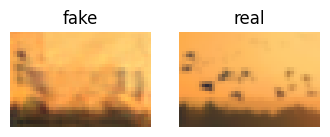

it scale 6:  56%|█████▌    | 2400/4300 [00:45<00:35, 52.81it/s]

[scale 6 | it 2400] 
[scale 6 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 1.6704

ratio_loss = 82.0534


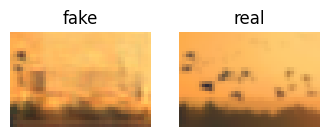

it scale 6:  70%|██████▉   | 3000/4300 [00:57<00:24, 53.16it/s]

[scale 6 | it 3000] 
[scale 6 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 1.6467

ratio_loss = 111.4985


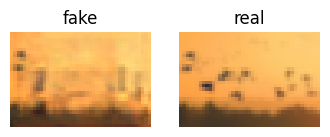

it scale 6:  84%|████████▎ | 3600/4300 [01:08<00:13, 53.74it/s]

[scale 6 | it 3600] 
[scale 6 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 1.6444

ratio_loss = 135.9480


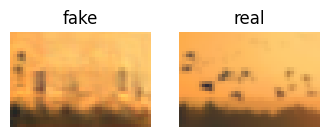

it scale 6:  98%|█████████▊| 4195/4300 [01:20<00:01, 53.15it/s]

[scale 6 | it 4200] 
[scale 6 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 1.6199

ratio_loss = 162.1142


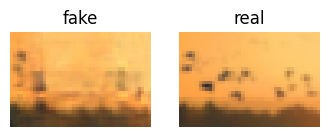

it scale 6: 100%|█████████▉| 4297/4300 [01:22<00:00, 53.29it/s]

[scale 6 | it 4299] 
[scale 6 | it 4299]  LR = 5.00e-04

 mean lost 100 iter 1.6379

ratio_loss = 125.3511


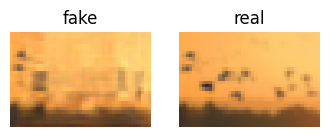

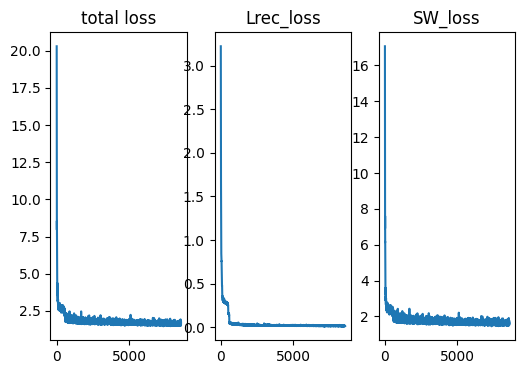

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/4600 [00:00<?, ?it/s]

[scale 5 | it 0] 
[scale 5 | it 0]  LR = 5.00e-04

 mean lost 100 iter 1.8973

ratio_loss = 24.6242


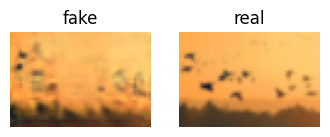

it scale 5:  13%|█▎        | 597/4600 [00:11<01:20, 49.59it/s]

[scale 5 | it 600] 
[scale 5 | it 600]  LR = 5.00e-04

 mean lost 100 iter 1.1450

ratio_loss = 54.2201


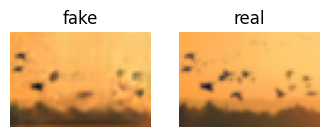

it scale 5:  26%|██▌       | 1194/4600 [00:23<00:53, 63.22it/s]

[scale 5 | it 1200] 
[scale 5 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 1.1062

ratio_loss = 64.4899


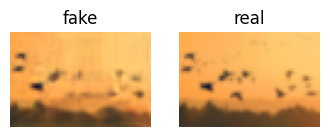

it scale 5:  39%|███▉      | 1796/4600 [00:34<00:54, 51.67it/s]

[scale 5 | it 1800] 
[scale 5 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 1.0861

ratio_loss = 67.8112


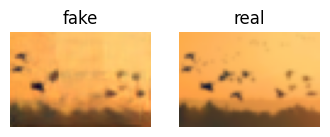

it scale 5:  52%|█████▏    | 2397/4600 [00:44<00:35, 62.66it/s]

[scale 5 | it 2400] 
[scale 5 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 1.0512

ratio_loss = 62.1708


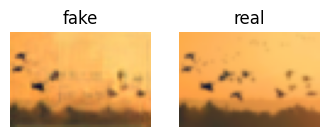

it scale 5:  65%|██████▌   | 2998/4600 [00:55<00:32, 49.67it/s]

[scale 5 | it 3000] 
[scale 5 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 1.0526

ratio_loss = 75.7109


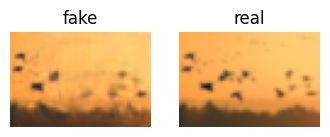

it scale 5:  78%|███████▊  | 3600/4600 [01:07<00:17, 56.89it/s]

[scale 5 | it 3600] 
[scale 5 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 1.0497

ratio_loss = 85.1027


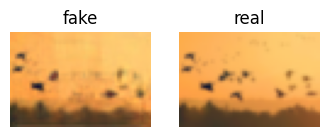

it scale 5:  91%|█████████▏| 4200/4600 [01:19<00:07, 50.70it/s]

[scale 5 | it 4200] 
[scale 5 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 1.0398

ratio_loss = 91.2124


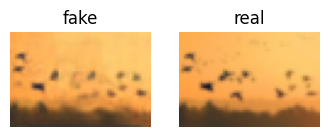

it scale 5: 100%|█████████▉| 4596/4600 [01:27<00:00, 50.20it/s]

[scale 5 | it 4599] 
[scale 5 | it 4599]  LR = 5.00e-04

 mean lost 100 iter 1.0370

ratio_loss = 130.5076


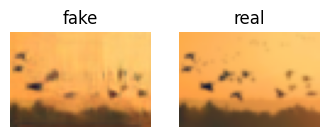

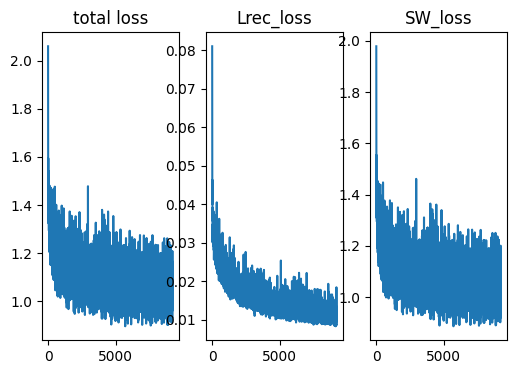

it scale 4:   0%|          | 0/4900 [00:00<?, ?it/s]

[scale 4 | it 0] 
[scale 4 | it 0]  LR = 5.00e-04

 mean lost 100 iter 7.6525

ratio_loss = 5.6975


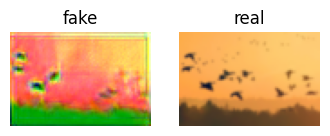

it scale 4:  12%|█▏        | 597/4900 [00:12<01:29, 47.89it/s]

[scale 4 | it 600] 
[scale 4 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.9070

ratio_loss = 46.5117


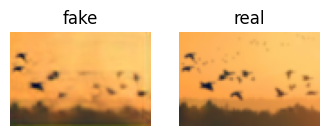

it scale 4:  24%|██▍       | 1199/4900 [00:25<01:16, 48.67it/s]

[scale 4 | it 1200] 
[scale 4 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.8796

ratio_loss = 46.0337


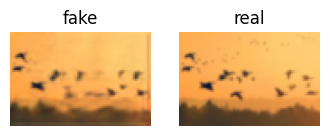

it scale 4:  37%|███▋      | 1796/4900 [00:37<01:03, 48.53it/s]

[scale 4 | it 1800] 
[scale 4 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.8645

ratio_loss = 59.3625


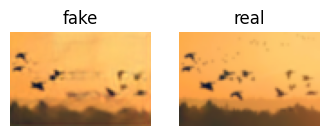

it scale 4:  49%|████▉     | 2396/4900 [00:50<00:53, 46.92it/s]

[scale 4 | it 2400] 
[scale 4 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.8689

ratio_loss = 56.9960


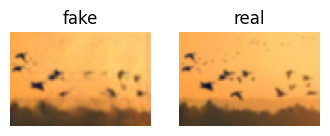

it scale 4:  61%|██████    | 2998/4900 [01:02<00:40, 46.88it/s]

[scale 4 | it 3000] 
[scale 4 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.8233

ratio_loss = 66.1256


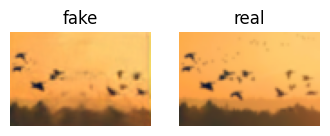

it scale 4:  73%|███████▎  | 3598/4900 [01:15<00:27, 47.73it/s]

[scale 4 | it 3600] 
[scale 4 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.8178

ratio_loss = 61.2409


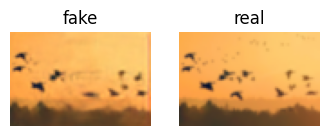

it scale 4:  86%|████████▌ | 4196/4900 [01:27<00:14, 47.20it/s]

[scale 4 | it 4200] 
[scale 4 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.8091

ratio_loss = 66.4616


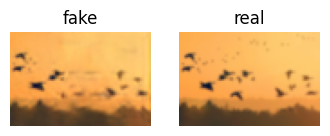

it scale 4:  98%|█████████▊| 4799/4900 [01:39<00:02, 48.53it/s]

[scale 4 | it 4800] 
[scale 4 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.8086

ratio_loss = 64.3329


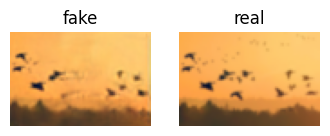

it scale 4: 100%|█████████▉| 4899/4900 [01:41<00:00, 48.18it/s]

[scale 4 | it 4899] 
[scale 4 | it 4899]  LR = 5.00e-04

 mean lost 100 iter 0.8016

ratio_loss = 59.8389


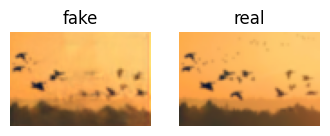

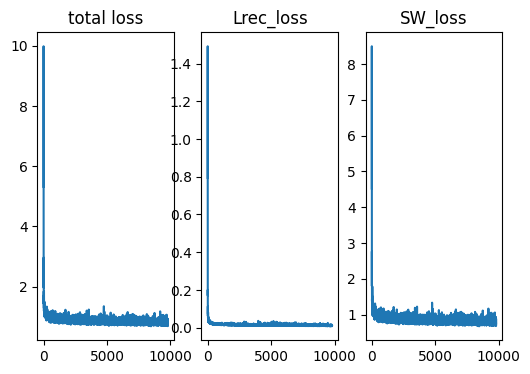

[init] copied weights from scale 4 → 3


it scale 3:   0%|          | 0/5200 [00:00<?, ?it/s]

[scale 3 | it 0] 
[scale 3 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.9071

ratio_loss = 19.8573


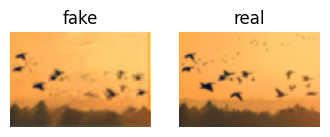

it scale 3:  11%|█▏        | 597/5200 [00:12<01:37, 47.43it/s]

[scale 3 | it 600] 
[scale 3 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.6428

ratio_loss = 50.8342


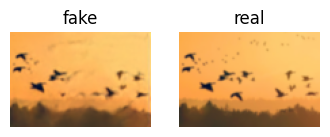

it scale 3:  23%|██▎       | 1197/5200 [00:25<01:24, 47.18it/s]

[scale 3 | it 1200] 
[scale 3 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.6453

ratio_loss = 48.7272


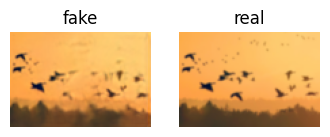

it scale 3:  35%|███▍      | 1797/5200 [00:38<01:16, 44.68it/s]

[scale 3 | it 1800] 
[scale 3 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.6291

ratio_loss = 56.5601


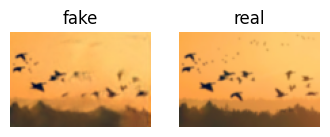

it scale 3:  46%|████▌     | 2397/5200 [00:51<00:59, 47.38it/s]

[scale 3 | it 2400] 
[scale 3 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.6340

ratio_loss = 53.7243


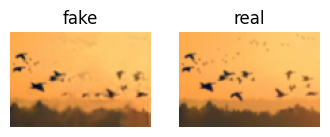

it scale 3:  58%|█████▊    | 3000/5200 [01:04<00:46, 47.80it/s]

[scale 3 | it 3000] 
[scale 3 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.6183

ratio_loss = 74.4513


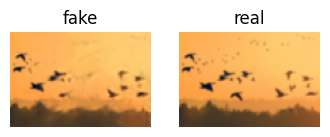

it scale 3:  69%|██████▉   | 3600/5200 [01:17<00:34, 47.02it/s]

[scale 3 | it 3600] 
[scale 3 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.6279

ratio_loss = 54.8674


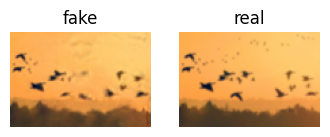

it scale 3:  81%|████████  | 4198/5200 [01:30<00:21, 46.04it/s]

[scale 3 | it 4200] 
[scale 3 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.6145

ratio_loss = 72.4590


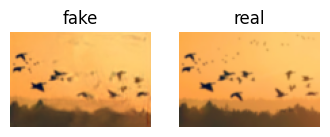

it scale 3:  92%|█████████▏| 4798/5200 [01:43<00:08, 46.67it/s]

[scale 3 | it 4800] 
[scale 3 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.6064

ratio_loss = 70.7345


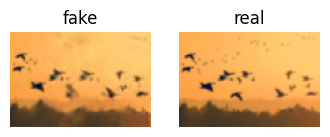

it scale 3: 100%|█████████▉| 5198/5200 [01:51<00:00, 47.25it/s]

[scale 3 | it 5199] 
[scale 3 | it 5199]  LR = 5.00e-04

 mean lost 100 iter 0.6310

ratio_loss = 63.7112


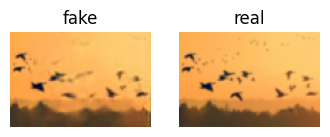

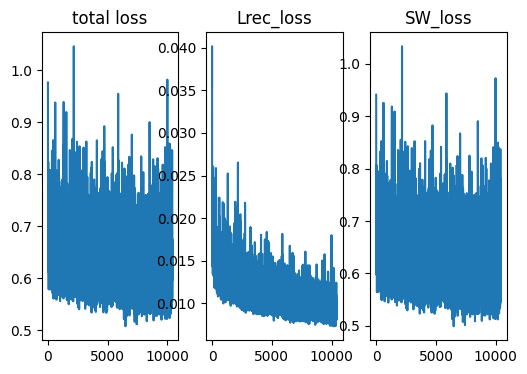

[init] copied weights from scale 3 → 2


it scale 2:   0%|          | 0/5500 [00:00<?, ?it/s]

[scale 2 | it 0] 
[scale 2 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.8237

ratio_loss = 24.3429


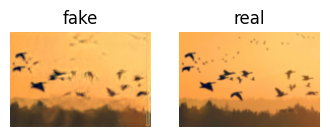

it scale 2:  11%|█         | 597/5500 [00:13<01:47, 45.69it/s]

[scale 2 | it 600] 
[scale 2 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.5088

ratio_loss = 43.9675


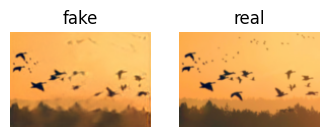

it scale 2:  22%|██▏       | 1197/5500 [00:26<01:33, 46.02it/s]

[scale 2 | it 1200] 
[scale 2 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.5144

ratio_loss = 47.7340


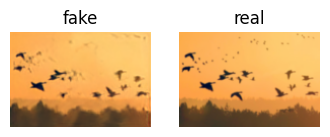

it scale 2:  33%|███▎      | 1797/5500 [00:39<01:19, 46.63it/s]

[scale 2 | it 1800] 
[scale 2 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.5031

ratio_loss = 48.0715


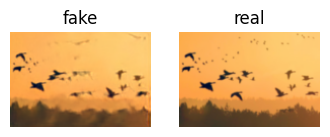

it scale 2:  44%|████▎     | 2397/5500 [00:52<01:07, 45.94it/s]

[scale 2 | it 2400] 
[scale 2 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.5068

ratio_loss = 55.9867


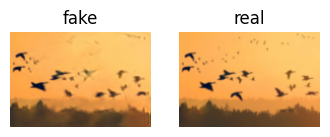

it scale 2:  54%|█████▍    | 2997/5500 [01:06<00:55, 44.85it/s]

[scale 2 | it 3000] 
[scale 2 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.5003

ratio_loss = 43.4865


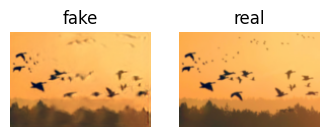

it scale 2:  65%|██████▌   | 3597/5500 [01:19<00:43, 44.11it/s]

[scale 2 | it 3600] 
[scale 2 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.4991

ratio_loss = 50.9639


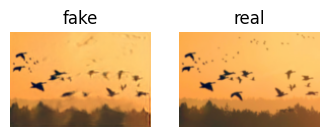

it scale 2:  76%|███████▋  | 4197/5500 [01:32<00:28, 46.38it/s]

[scale 2 | it 4200] 
[scale 2 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.4933

ratio_loss = 45.6365


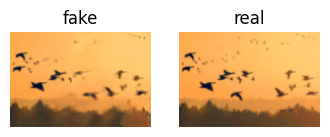

it scale 2:  87%|████████▋ | 4797/5500 [01:46<00:15, 44.61it/s]

[scale 2 | it 4800] 
[scale 2 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.4898

ratio_loss = 52.0626


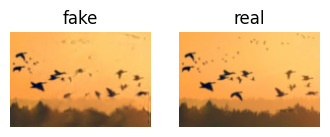

it scale 2:  98%|█████████▊| 5397/5500 [01:59<00:02, 45.49it/s]

[scale 2 | it 5400] 
[scale 2 | it 5400]  LR = 5.00e-04

 mean lost 100 iter 0.4879

ratio_loss = 54.9883


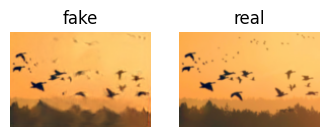

it scale 2: 100%|█████████▉| 5497/5500 [02:01<00:00, 42.21it/s]

[scale 2 | it 5499] 
[scale 2 | it 5499]  LR = 5.00e-04

 mean lost 100 iter 0.4932

ratio_loss = 55.9610


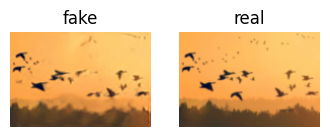

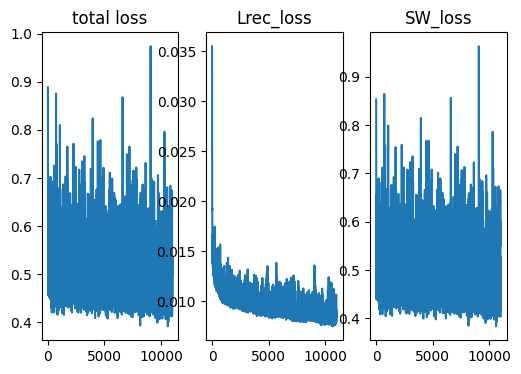

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/5800 [00:00<?, ?it/s]

[scale 1 | it 0] 
[scale 1 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.4590

ratio_loss = 21.3850


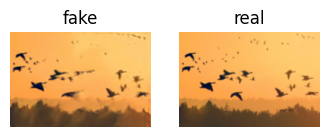

it scale 1:  10%|█         | 597/5800 [00:14<02:04, 41.79it/s]

[scale 1 | it 600] 
[scale 1 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.4085

ratio_loss = 31.4395


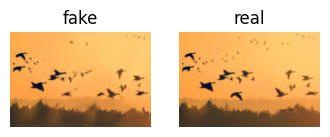

it scale 1:  21%|██        | 1197/5800 [00:28<01:46, 43.30it/s]

[scale 1 | it 1200] 
[scale 1 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.4052

ratio_loss = 35.7728


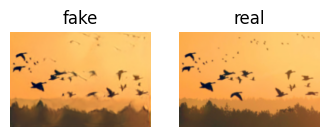

it scale 1:  31%|███       | 1797/5800 [00:42<01:36, 41.55it/s]

[scale 1 | it 1800] 
[scale 1 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.4178

ratio_loss = 43.8866


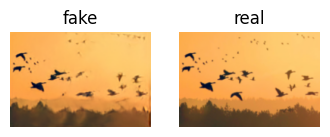

it scale 1:  41%|████▏     | 2399/5800 [00:58<01:21, 41.69it/s]

[scale 1 | it 2400] 
[scale 1 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.4084

ratio_loss = 37.9766


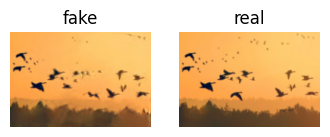

it scale 1:  52%|█████▏    | 2999/5800 [01:12<01:06, 42.15it/s]

[scale 1 | it 3000] 
[scale 1 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.4058

ratio_loss = 39.6431


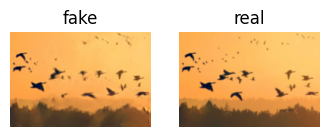

it scale 1:  62%|██████▏   | 3599/5800 [01:26<00:51, 42.83it/s]

[scale 1 | it 3600] 
[scale 1 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.4063

ratio_loss = 53.3038


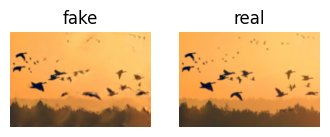

it scale 1:  72%|███████▏  | 4200/5800 [01:40<00:37, 42.21it/s]

[scale 1 | it 4200] 
[scale 1 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.3982

ratio_loss = 36.1240


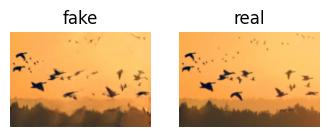

it scale 1:  83%|████████▎ | 4800/5800 [01:55<00:23, 41.73it/s]

[scale 1 | it 4800] 
[scale 1 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.4091

ratio_loss = 43.6806


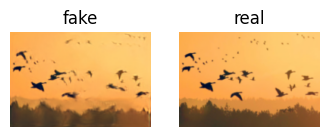

it scale 1:  93%|█████████▎| 5400/5800 [02:09<00:09, 42.36it/s]

[scale 1 | it 5400] 
[scale 1 | it 5400]  LR = 5.00e-04

 mean lost 100 iter 0.4014

ratio_loss = 39.2648


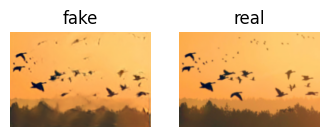

it scale 1: 100%|█████████▉| 5795/5800 [02:18<00:00, 42.49it/s]

[scale 1 | it 5799] 
[scale 1 | it 5799]  LR = 5.00e-04

 mean lost 100 iter 0.4016

ratio_loss = 33.4277


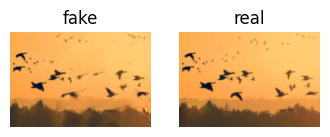

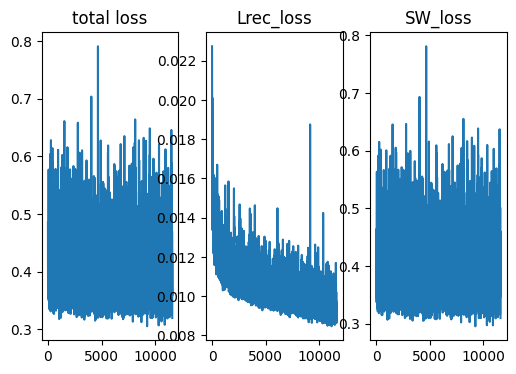

it scale 0:   0%|          | 0/6100 [00:00<?, ?it/s]

[scale 0 | it 0] 
[scale 0 | it 0]  LR = 5.00e-04

 mean lost 100 iter 12.4542

ratio_loss = 3.8519


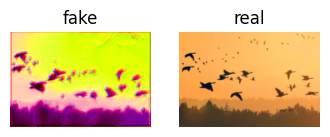

it scale 0:  10%|▉         | 598/6100 [00:27<04:08, 22.13it/s]

[scale 0 | it 600] 
[scale 0 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.4633

ratio_loss = 11.0322


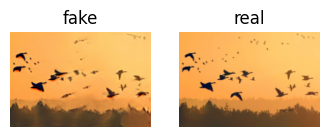

it scale 0:  20%|█▉        | 1198/6100 [00:54<03:41, 22.10it/s]

[scale 0 | it 1200] 
[scale 0 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.4189

ratio_loss = 11.2566


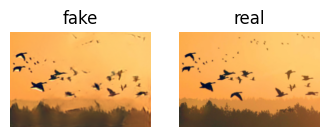

it scale 0:  29%|██▉       | 1798/6100 [01:22<03:14, 22.09it/s]

[scale 0 | it 1800] 
[scale 0 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.3932

ratio_loss = 16.0790


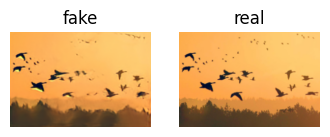

it scale 0:  39%|███▉      | 2398/6100 [01:49<02:48, 21.93it/s]

[scale 0 | it 2400] 
[scale 0 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.3966

ratio_loss = 13.1144


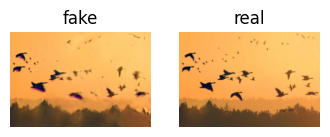

it scale 0:  49%|████▉     | 2998/6100 [02:16<02:26, 21.17it/s]

[scale 0 | it 3000] 
[scale 0 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.3865

ratio_loss = 19.0018


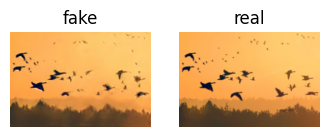

it scale 0:  59%|█████▉    | 3598/6100 [02:44<01:53, 22.03it/s]

[scale 0 | it 3600] 
[scale 0 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.3636

ratio_loss = 19.6510


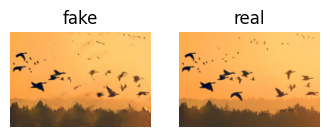

it scale 0:  69%|██████▉   | 4198/6100 [03:11<01:26, 21.95it/s]

[scale 0 | it 4200] 
[scale 0 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.3756

ratio_loss = 18.0149


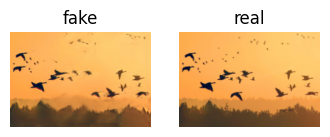

it scale 0:  79%|███████▊  | 4798/6100 [03:38<00:59, 21.86it/s]

[scale 0 | it 4800] 
[scale 0 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.3826

ratio_loss = 17.3429


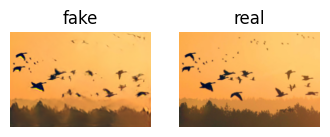

it scale 0:  88%|████████▊ | 5398/6100 [04:06<00:31, 22.02it/s]

[scale 0 | it 5400] 
[scale 0 | it 5400]  LR = 5.00e-04

 mean lost 100 iter 0.3782

ratio_loss = 17.0175


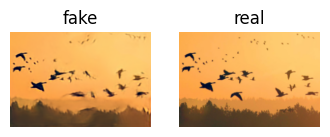

it scale 0:  98%|█████████▊| 5998/6100 [04:33<00:04, 21.66it/s]

[scale 0 | it 6000] 
[scale 0 | it 6000]  LR = 5.00e-04

 mean lost 100 iter 0.3770

ratio_loss = 20.8135


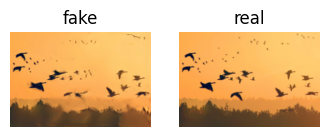

it scale 0: 100%|█████████▉| 6097/6100 [04:38<00:00, 22.07it/s]

[scale 0 | it 6099] 
[scale 0 | it 6099]  LR = 5.00e-04

 mean lost 100 iter 0.3671

ratio_loss = 20.5229


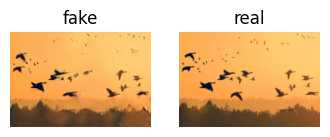

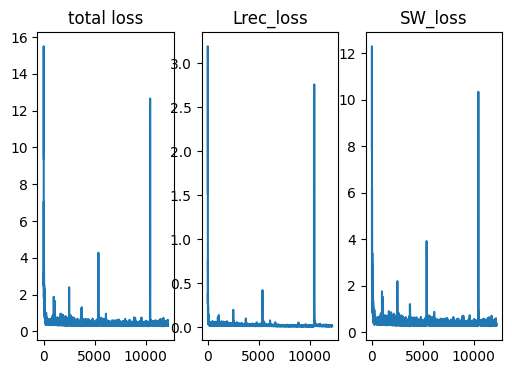

In [40]:
torch.random.manual_seed(1)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
base_iter   = 4000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
lamda_swd = 10

for G in Genarators:
    G.apply(weights_init)


# reset des optim.
optimizer_G = []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G = []

step_size   = 20000        # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G in optimizer_G:
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )

z_star   = torch.randn_like(pyramids[0][-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(pyramids[0][-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev_full(k: int, b: int):
    """
    Renvoie prev_img pour l'échelle k (shape = (b, C, Hk, Wk)) :
      • on part d'une image nulle au coarse (N-1) ;
      • on applique tous les G gelés (N-1 … k+1) avec bruit propre à CHAQUE
        élément du batch ;
      • on upsample à la résolution k.
    """
    # ----------- 0. raccourci coarse ---------------------------------------
    if k == N - 1:                       # échelle la plus grossière
        _, C, Hc, Wc = pyramids[0][k].shape   # scales[k] == (1,C,H,W)
        return torch.zeros(b, C, Hc, Wc, device=device)

    # ----------- 1. point de départ (N-1) ----------------------------------
    _, C, Hc, Wc = pyramids[0][-1].shape
    img = torch.zeros(b, C, Hc, Wc, device=device)        # (b,C,Hc,Wc)

    z  = torch.randn_like(img) * sigma_n[N - 1]
    img = Genarators[N - 1](z)                            # (b,C,Hc,Wc)

    # ----------- 2. remontée N-2 … k+1 -------------------------------------
    for s in range(N - 2, k, -1):
        _, _, Hs, Ws = pyramids[0][s].shape

        # upsample vers la taille courante s
        img_up = F.interpolate(img, size=(Hs, Ws),
                               mode='bilinear', align_corners=False)

        # bruit propre à chaque élément du batch
        z = torch.randn_like(img_up) * sigma_n[s]

        # passage résiduel : G_s(z + img_up) + img_up
        img = Genarators[s](z + img_up) + img_up

    # ----------- 3. dernier upsample vers l'échelle k ----------------------
    _, _, Hk, Wk = pyramids[0][k].shape
    prev_img = F.interpolate(img, size=(Hk, Wk),
                             mode='bilinear', align_corners=False)
    return prev_img 


# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    xk_real = pyramids[0][current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)
    total_loss_list = []
    Lrec_loss_list = []
    Sw_loss_list = []
    # itérations par scale
    iter_per_scale = base_iter+ 300*n
    
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):
        idx = torch.randint(0, 1, (b,))
        xk_real = torch.stack([pyramids[i][current_res].squeeze(0) for i in idx]).to(device)
        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res,b)

        
        for g_idx in range(n_Generator):
            Sw_loss = []
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            patch_size = [4,8,10,20]
            stride = [2,4,5,10]
            for ps,s in zip(patch_size,stride) : 
                real_patches_flat = extract_patches_batched(xk_real, ps, s)
                fake_patches_flat = extract_patches_batched(fake, ps, s)

                # Calculate the Sliced Wasserstein Distance
                swd = sliced_wasserstein_distance(real_patches_flat, fake_patches_flat, num_projections=128)
                Sw_loss.append(lamda_swd*swd)
                
            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star.repeat(b,1,1,1)                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                up_fixed = up_fixed.repeat(b,1,1,1)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec_loss = alpha_rec * F.mse_loss(rec_out, xk_real)
            total_loss = Lrec_loss + sum(Sw_loss)
            (total_loss).backward()
            total_loss_list.append(total_loss.item())
            Lrec_loss_list.append(Lrec_loss.item())
            Sw_loss_list.append(sum(Sw_loss).item())
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 600 == 0 or it==iter_per_scale-1):
            ratio_loss = abs(sum(Sw_loss).item())/(abs(Lrec_loss.item()) + 1e-8)

            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            print(f"[scale {current_res} | it {it}] ")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")
            print(f'\n mean lost 100 iter {np.mean(total_loss_list[-100:]):.4f}')
            print(f"\nratio_loss = {ratio_loss:.4f}")
            
        

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake[0].detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)
    plt.figure(figsize=(6,4))
    
    plt.subplot(1,3,1)
    plt.plot(total_loss_list)
    plt.title("total loss")
    plt.subplot(1,3,2)
    plt.plot(Lrec_loss_list)
    plt.title("Lrec_loss")
    plt.subplot(1,3,3)
    plt.plot(Sw_loss_list)
    plt.title("SW_loss")
    
    plt.show()

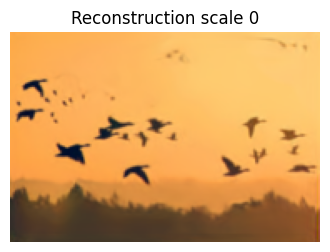

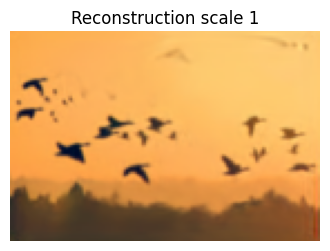

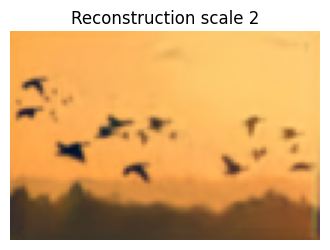

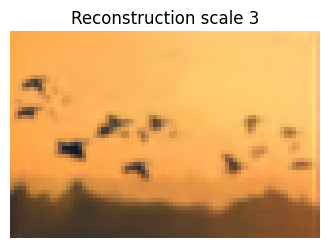

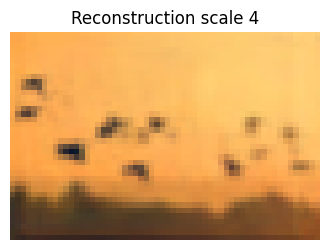

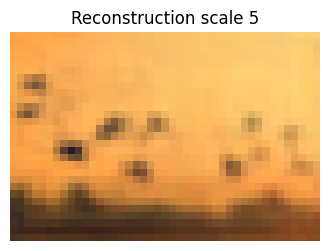

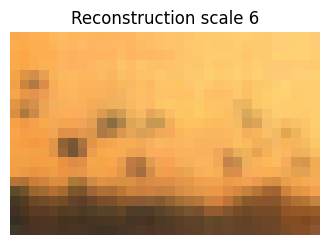

In [43]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:])

SAVING GENERATORS AND NECESSARY PARAMS

In [45]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "sw_patch_big_1" 
image_name = "oiseau"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "r"                 : float(4/3),
        "lr"             : lr,
        "betas"          : betas,
        "patch_size": [10.20],
        "n_Generator"    : n_Generator,
        "base_iter" : base_iter,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "lambda_sw" : lamda_swd,
        "stride" : [5,10],
        "comment"        : "Sin Gan avec de la data aug sur l'image réele. + swd trainning on multiple patch_size",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


Générateurs sauvegardés     -> models/oiseau/sw_patch_big_1/generators.pt
Description créée           -> models/oiseau/sw_patch_big_1/Description.txt
sigma_n sauvegardé          -> models/oiseau/sw_patch_big_1/sigma_n.json
z_star sauvegardé           -> models/oiseau/sw_patch_big_1/z_star.pt
